# Import required dependencies

In [ ]:
import keras
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Softmax, Dropout,LSTM
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

import numpy as np
import numpy.random as random
from nltk.tokenize import word_tokenize
import nltk
from random import sample

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline

In [ ]:
UNK_TOKEN = '__unk__'
MAX_SEQUENCE_LENGTH = 70
VOCAB_SIZE = 15000

In [ ]:
#load data
data=pd.read_csv("Sentiment.csv",parse_dates=['Date'])
data=data[['Date','News','textblobResult']]
data=data.sort_values('Date')
data=data.reset_index(drop=True)
data=data.rename(columns={'textblobResult':'Result'})
data

,Date,News,Result
0,2012-05-06,"May 6, 2012 (LBO) - Sri Lanka's foreign reserv...",Negative
1,2012-06-27,Sri Lankan shares up 0.11 percent; large deals...,Positive
2,2012-06-28,Sri Lanka stocks down 0.80 percent,Negative
3,2012-06-29,"Sri Lanka stocks close up 0.20 pct, rupee steady",Positive
4,2012-07-02,"Sri Lankan stocks down 0.2-pct, turnover lowes...",Negative
...,...,...,...
1535,2020-11-30,Sustainable blue-economy is future of Bay of B...,Neutral
1536,2020-12-01,Private sector an equal partner in economic re...,Neutral
1537,2020-12-08,Renuka Holding PLC to raise Rs.1Bn via rights ...,Positive
1538,2020-12-24,Central Bank expects rupee to appreciate withi...,Positive


In [ ]:
classes = {"Neutral":0,"Positive":1,"Negative":2}

classStats = data.groupby('Result').count()
classStats=classStats.reset_index()
classStats

,Result,Date,News
0,Negative,481,481
1,Neutral,692,692
2,Positive,367,367


In [ ]:
newsdf=data

<AxesSubplot:xlabel='Result', ylabel='count'>

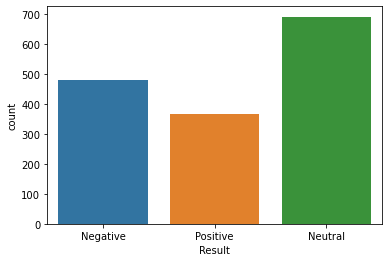

In [ ]:
import seaborn as sns
sns.countplot(x="Result", data=newsdf)

In [ ]:
#subsmapling to create a balanced data set

In [ ]:
#read the final index to retrieve the dates
indexdf=pd.read_csv("finalindex.csv")
indexdf=indexdf.iloc[:,1:]
newsdf=pd.DataFrame()
newsdf['Trading Date']=indexdf['Trading Date'].values
data=data.rename({"Date":"Trading Date"},axis=1)
newsdf['Trading Date']=pd.to_datetime(newsdf['Trading Date'])
data['Trading Date']=pd.to_datetime(data['Trading Date'])
newsdf

,Trading Date
0,2012-06-27
1,2012-06-28
2,2012-06-29
3,2012-07-02
4,2012-07-04
...,...
1951,2020-12-23
1952,2020-12-24
1953,2020-12-28
1954,2020-12-30


In [ ]:
newsdf=newsdf.merge(data, how = 'left', on = ['Trading Date'])
newsdf=newsdf.drop_duplicates(subset="Trading Date")
newsdf=newsdf.reset_index(drop=True)
newsdf

,Trading Date,News,Result
0,2012-06-27,Sri Lankan shares up 0.11 percent; large deals...,Positive
1,2012-06-28,Sri Lanka stocks down 0.80 percent,Negative
2,2012-06-29,"Sri Lanka stocks close up 0.20 pct, rupee steady",Positive
3,2012-07-02,"Sri Lankan stocks down 0.2-pct, turnover lowes...",Negative
4,2012-07-04,Sri Lankan stocks down 0.12%,Negative
...,...,...,...
1951,2020-12-23,NaN,NaN
1952,2020-12-24,Central Bank expects rupee to appreciate withi...,Positive
1953,2020-12-28,NaN,NaN
1954,2020-12-30,NaN,NaN


In [ ]:
newsdf['Result'].value_counts()

Neutral     482
Negative    325
Positive    241
Name: Result, dtype: int64

<AxesSubplot:xlabel='Result', ylabel='count'>

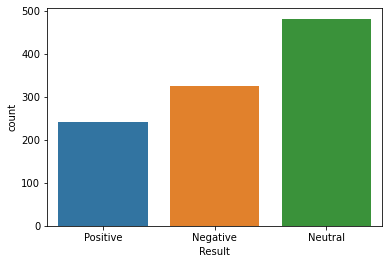

In [ ]:
sns.countplot(x="Result", data=newsdf)

In [ ]:
nanlist=(newsdf[newsdf['News'].isnull()].index.tolist())
len(nanlist)

908

In [ ]:
sample(newsdf[newsdf['Result']=='Neutral']['News'].to_list(),1)[0]

'Asian shares edge up on Wall Street lead, pre-Fed nerves limit gains'

In [ ]:
from random import sample

#randomly oversample to fill the missing data points
#for neutral
sampleneutral=sample(nanlist,250)
for i in sampleneutral:
    newsdf['Result'][i]="Neutral"
    newsdf['News'][i]=str(sample(newsdf[newsdf['Result']=='Neutral']['News'].to_list(),1)[0])
nanlist=(newsdf[newsdf['News'].isnull()].index.tolist())

#for negative
samplenegative=sample(nanlist,300)
for i in samplenegative:
    newsdf['Result'][i]="Negative"
    newsdf['News'][i]=str(sample(newsdf[newsdf['Result']=='Negative']['News'].to_list(),1)[0])
nanlist=(newsdf[newsdf['News'].isnull()].index.tolist())

#for negative
samplepositive=sample(nanlist,358)
for i in samplepositive:
    newsdf['Result'][i]="Positive"
    newsdf['News'][i]=str(sample(newsdf[newsdf['Result']=='Positive']['News'].to_list(),1)[0])

# Data Cleaning

In [ ]:
#replace lables with integers
label={'Neutral':0,'Positive':1,'Negative':2}
newsdf=newsdf.replace({"Result": label})
newsdf

,Trading Date,News,Result
0,2012-06-27,Sri Lankan shares up 0.11 percent; large deals...,1
1,2012-06-28,Sri Lanka stocks down 0.80 percent,2
2,2012-06-29,"Sri Lanka stocks close up 0.20 pct, rupee steady",1
3,2012-07-02,"Sri Lankan stocks down 0.2-pct, turnover lowes...",2
4,2012-07-04,Sri Lankan stocks down 0.12%,2
...,...,...,...
1951,2020-12-23,Sri Lanka stocks close higher,1
1952,2020-12-24,Central Bank expects rupee to appreciate withi...,1
1953,2020-12-28,Sri Lanka stocks down 0.2-pct,2
1954,2020-12-30,Sri Lanka economy boosted after election by lo...,1


In [ ]:
import re
from gensim import utils
import gensim
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem import WordNetLemmatizer


# new model

In [ ]:
temp=newsdf
temp

,Trading Date,News,Result
0,2012-06-27,Sri Lankan shares up 0.11 percent; large deals...,1
1,2012-06-28,Sri Lanka stocks down 0.80 percent,2
2,2012-06-29,"Sri Lanka stocks close up 0.20 pct, rupee steady",1
3,2012-07-02,"Sri Lankan stocks down 0.2-pct, turnover lowes...",2
4,2012-07-04,Sri Lankan stocks down 0.12%,2
...,...,...,...
1951,2020-12-23,Sri Lanka stocks close higher,1
1952,2020-12-24,Central Bank expects rupee to appreciate withi...,1
1953,2020-12-28,Sri Lanka stocks down 0.2-pct,2
1954,2020-12-30,Sri Lanka economy boosted after election by lo...,1


In [ ]:
lemmatizer = WordNetLemmatizer()

def dataclean(text):
    #remove urls
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r'', text)
    
    #remove emails
    text = re.sub('\S*@\S*\s?', '', text)

    # Remove new line characters
    text = re.sub('\s+', ' ', text)

    # Remove distracting single quotes
    text = re.sub("\'", "", text)
    
    # Remove hashtags
    text = re.sub("#'", "", text)
    
    # Remove other characters
    removelist=['.',',','(',')','()','%']
    text=''.join([c for c in text if c not in removelist])
    
    #lemmatizing
    word_list = nltk.word_tokenize(text)   
    text = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    
    return text

In [ ]:
temp['News']=temp['News'].apply(lambda x: x.lower())
cloudstring=''
for i in temp.index:
    temp['News'][i]=dataclean(temp['News'][i])
    cloudstring=cloudstring+' '+temp['News'][i]
temp.head()

,Trading Date,News,Result
0,2012-06-27,sri lankan share up 011 percent ; large deal i...,1
1,2012-06-28,sri lanka stock down 080 percent,2
2,2012-06-29,sri lanka stock close up 020 pct rupee steady,1
3,2012-07-02,sri lankan stock down 02-pct turnover lowest i...,2
4,2012-07-04,sri lankan stock down 012,2


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(temp['News'])

df2 = pd.DataFrame(common_words, columns = ['News' , 'count'])
df2=df2.iloc[2:,:]
df2.groupby('News').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in News')


In [ ]:
#tokenization and vectorization
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=1000, split=" ")
tokenizer.fit_on_texts(temp['News'].values)

X = tokenizer.texts_to_sequences(temp['News'].values)
X = pad_sequences(X) 
X[:5]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,  22,  12,
          6, 908, 159, 328, 244,  10, 198, 181],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   1,   2,   3,   7, 909, 159],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          2,   3,   5,   6, 391,   4,   9,  31],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   

In [ ]:
from keras.layers import Dense, LSTM, Embedding, Dropout

model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 47, 256)           1280000   
                                                                 
 dropout_1 (Dropout)         (None, 47, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 47, 256)           525312    
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,002,819
Trainable params: 2,002,819
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y = pd.get_dummies(temp['Result']).values
[print(temp['Result'][i], y[i]) for i in range(0,5)]

1 [0 1 0]
2 [0 0 1]
1 [0 1 0]
2 [0 0 1]
2 [0 0 1]


[None, None, None, None, None]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


In [ ]:
batch_size = 32
epochs = 5

history =model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=2)

Epoch 1/5
35/35 - 51s - loss: 1.0561 - accuracy: 0.4658 - val_loss: 0.9651 - val_accuracy: 0.6022 - 51s/epoch - 1s/step
Epoch 2/5
35/35 - 13s - loss: 0.6077 - accuracy: 0.7607 - val_loss: 0.5571 - val_accuracy: 0.7847 - 13s/epoch - 381ms/step
Epoch 3/5
35/35 - 14s - loss: 0.2613 - accuracy: 0.9087 - val_loss: 0.3675 - val_accuracy: 0.8905 - 14s/epoch - 408ms/step
Epoch 4/5
35/35 - 19s - loss: 0.1251 - accuracy: 0.9543 - val_loss: 0.3395 - val_accuracy: 0.9015 - 19s/epoch - 547ms/step
Epoch 5/5
35/35 - 23s - loss: 0.0852 - accuracy: 0.9680 - val_loss: 0.4011 - val_accuracy: 0.8650 - 23s/epoch - 651ms/step


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


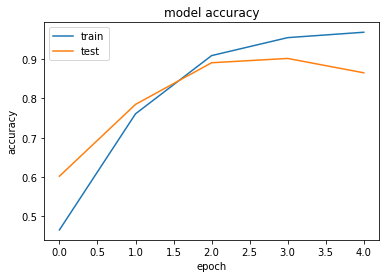

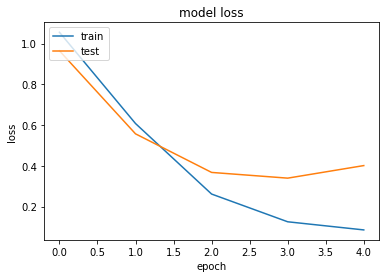

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test)

[print(temp['News'][i], predictions[i], y_test[i]) for i in range(0, 5)]

sri lankan share up 011 percent ; large deal in john keells [3.7344403e-04 3.5331858e-04 9.9927324e-01] [0 0 1]
sri lanka stock down 080 percent [3.2821478e-04 2.1556548e-04 9.9945623e-01] [0 0 1]
sri lanka stock close up 020 pct rupee steady [0.03336843 0.9298767  0.03675495] [0 1 0]
sri lankan stock down 02-pct turnover lowest in three year [0.9895839  0.00582734 0.00458871] [1 0 0]
sri lankan stock down 012 [1.4919616e-04 8.0812410e-05 9.9976999e-01] [0 0 1]


[None, None, None, None, None]

In [ ]:
pos_count, neu_count, neg_count = 0, 0, 0
real_pos, real_neu, real_neg = 0, 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==2:
        pos_count += 1
    elif np.argmax(prediction)==1:
        neg_count += 1
    else:
        neu_count += 1
    
    if np.argmax(y_test[i])==2:
        real_pos += 1
    elif np.argmax(y_test[i])==1:    
        real_neg += 1
    else:
        real_neu +=1

print('Positive predictions:', pos_count)
print('Neutral predictions:', neu_count)
print('Negative predictions:', neg_count)
print('Real positive:', real_pos)
print('Real neutral:', real_neu)
print('Real negative:', real_neg)

Positive predictions: 187
Neutral predictions: 233
Negative predictions: 167
Real positive: 186
Real neutral: 240
Real negative: 161


In [ ]:
est_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Set Accuracy: %0.2f%%"%(test_acc*100))

19/19 [==============================] - 2s 103ms/step - loss: 0.2813 - accuracy: 0.9029
Test Set Accuracy: 90.29%


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

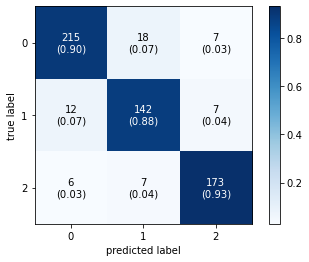

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)


plot_confusion_matrix(confusion_matrix(np.argmax(y_test, axis=1), y_pred),show_absolute=True,show_normed=True,colorbar=True)


In [ ]:
y_test2=[]
y_train2=[]
for i in y_test:
    ob=i
    ind=np.where(ob==1)
    y_test2.append(ind[0][0])
y_test2 = np.array(y_test2)

for i in y_train:
    ob=i
    ind=np.where(ob==1)
    y_train2.append(ind[0][0])
y_train2 = np.array(y_train2)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test2, y_pred, target_names=['Negative (2 Class)', 'Positive (1 Class)', 'Neutral (0 Class)']))

                    precision    recall  f1-score   support

Negative (2 Class)       0.92      0.90      0.91       240
Positive (1 Class)       0.85      0.88      0.87       161
 Neutral (0 Class)       0.93      0.93      0.93       186

          accuracy                           0.90       587
         macro avg       0.90      0.90      0.90       587
      weighted avg       0.90      0.90      0.90       587



In [ ]:
cloudstring=cloudstring.replace('sri lanka','')
cloudstring=cloudstring.replace('close','')

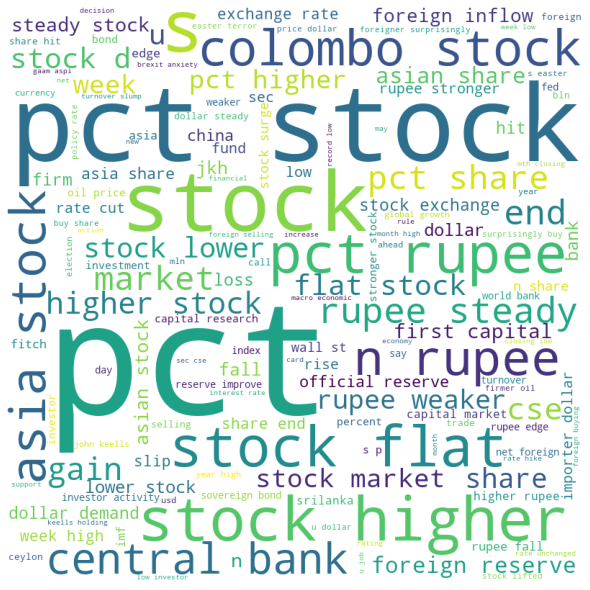

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                #stopwords = stopwords,
                min_font_size = 10).generate(cloudstring)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Parameter Tuning

In [ ]:
newsdf.to_csv("newsfinal.csv")

NameError: ignored